In [1]:
import os
import random
import numpy as np
import scipy.io
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.animation import FuncAnimation, PillowWriter
!pip install opencv-python
!pip install torchsummary
import cv2
import torchvision.transforms.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

import torch
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr_loss, structural_similarity as ssim_loss

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.9 MB/s eta 0:00:00


In [2]:
!pip install -q torch torchvision timm einops ptflops scikit-image opencv-python pillow tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title Librerias
import torch
import torchvision.transforms.functional as TF
import timm
import cv2
from PIL import Image
from tqdm import tqdm
import io
import os
from google.colab import drive, files
# from google.colab.patches import cv2_imshow
from skimage.metrics import peak_signal_noise_ratio as psnr_loss, structural_similarity as ssim_loss, mean_squared_error as mse_loss

In [5]:
#@title Repositorio
!git clone https://github.com/ZhendongWang6/Uformer.git
%cd Uformer

from model import Uformer
from losses import CharbonnierLoss

Cloning into 'Uformer'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 137 (delta 57), reused 45 (delta 45), pack-reused 64 (from 2)
Receiving objects: 100% (137/137), 2.15 MiB | 11.68 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/Uformer


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [6]:
import torchvision.transforms as T
import random

class NYUDatasetNoDepth(Dataset):
    def __init__(self,
                 rgb_dir,
                 input_size=256,
                 dof_levels=5):
        self.rgb_dir    = rgb_dir
        self.input_size = input_size
        self.dof_levels = dof_levels

        # Solo archivos válidos
        self.base_files = sorted([
            f for f in os.listdir(rgb_dir)
            if os.path.isfile(os.path.join(rgb_dir, f)) and f.endswith('.png')
        ])

        self.transform = T.Compose([
            T.Resize((self.input_size, self.input_size)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.base_files)

    def __getitem__(self, idx):
        name = self.base_files[idx]
        dof = random.randint(0, self.dof_levels - 1)  # dof aleatorio para cada imagen

        # Cargar imagen con desenfoque
        dof_path = os.path.join(self.rgb_dir, f'dof{dof}', name)
        if not os.path.isfile(dof_path):
            raise FileNotFoundError(f"No se encontró la imagen desenfocada: {dof_path}")

        # Cargar ground truth (imagen nítida)
        gt_path = os.path.join(self.rgb_dir, name)

        dof_img = Image.open(dof_path).convert('RGB')
        gt_img  = Image.open(gt_path).convert('RGB')

        # Transformar (redimensionar y a tensor)
        dof_img = self.transform(dof_img)
        gt_img  = self.transform(gt_img)

        return {
            'image': dof_img,
            'gt': gt_img,
            'dof': dof,
            'name': name
        }

In [7]:
rgb_dir = '/content/drive/MyDrive/UIS/Handson/nyu_rgb'
dataset = NYUDatasetNoDepth(
    rgb_dir=rgb_dir,
    input_size=256,
    dof_levels=5,
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

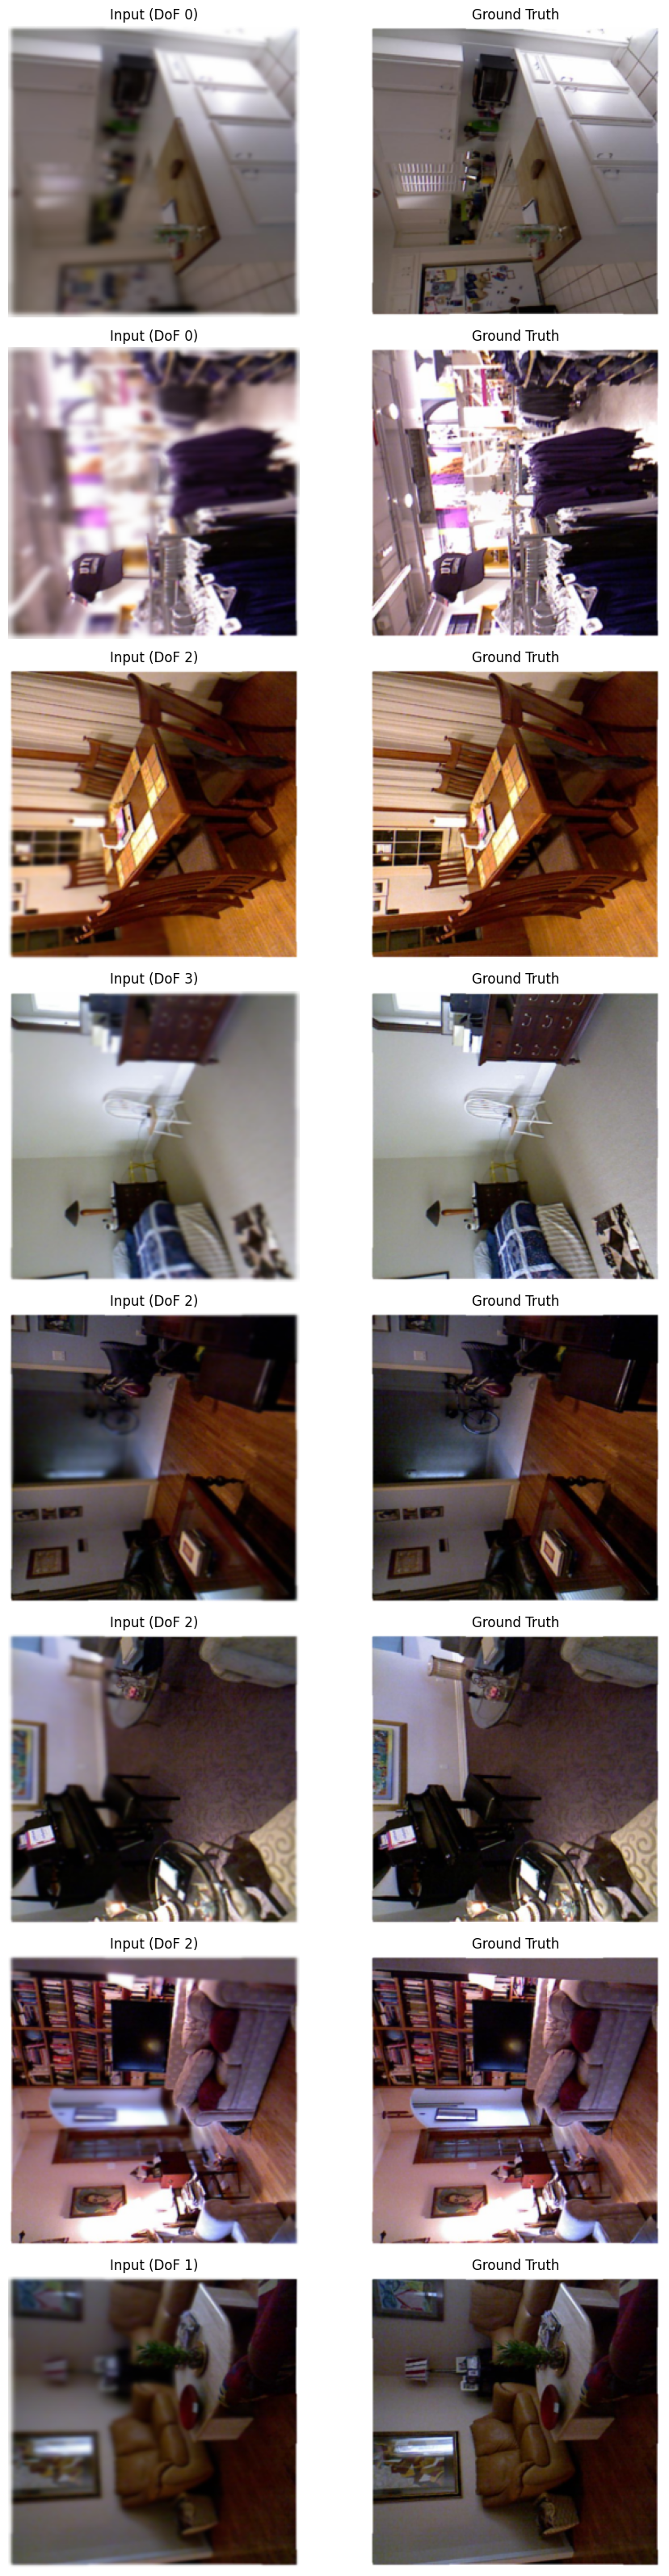

In [8]:
def show_batch(batch, max_images=8):
    import matplotlib.pyplot as plt
    import torchvision.transforms.functional as F

    images = batch['image']
    gts    = batch['gt']
    dofs   = batch['dof']

    batch_size = min(images.size(0), max_images)
    fig, axs = plt.subplots(batch_size, 2, figsize=(10, 4 * batch_size))

    if batch_size == 1:
        axs = axs.reshape(1, 2)

    for i in range(batch_size):
        img = F.to_pil_image(images[i].cpu())
        gt  = F.to_pil_image(gts[i].cpu())
        dof = dofs[i].item() if hasattr(dofs[i], 'item') else int(dofs[i])

        axs[i, 0].imshow(img)
        axs[i, 0].set_title(f'Input (DoF {dof})')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(gt)
        axs[i, 1].set_title('Ground Truth')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

batch = next(iter(dataloader))
show_batch(batch)

In [13]:
half_size = len(dataset) // 2
remaining_size = len(dataset) - half_size

half_dataset, _ = random_split(dataset, [half_size, remaining_size])
train_size = int(0.8 * len(half_dataset))
test_size = len(half_dataset) - train_size

train_dataset, test_dataset = random_split(half_dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# Modelo, pérdida y optimizador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Uformer(img_size=256, embed_dim=32, win_size=8, token_projection='linear', token_mlp='leff', depths=[1, 2, 8, 8, 2, 8, 8, 2, 1], modulator=True, dd_in=3).to(device)
criterion = CharbonnierLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 3

In [ ]:
# Entrenamiento
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
    inputs = batch['image'].to(device)
    targets = batch['gt'].to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)

  epoch_loss = running_loss / len(train_loader.dataset)
  print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.6f}")

  torch.save(model.state_dict(), f'uformer_epoch{epoch+1}.pth')

Epoch 1/3:  70%|██████▉   | 51/73 [2:10:15<56:33, 154.24s/it]

In [ ]:
# 4. Evaluación en test
model.eval()
psnr_list, ssim_list = [], []
with torch.no_grad():
  for batch in tqdm(test_loader, desc="Evaluando en test"):
    inputs = batch['image'].to(device)
    targets = batch['gt'].to(device)
    outputs = model(inputs)
    outputs = torch.clamp(outputs, 0, 1)

    outputs_np = outputs.cpu().numpy()
    targets_np = targets.cpu().numpy()
    for i in range(outputs_np.shape[0]):
      out_img = outputs_np[i].transpose(1,2,0)
      gt_img = targets_np[i].transpose(1,2,0)
      psnr = psnr_loss(out_img, gt_img, data_range=1)
      ssim = ssim_loss(out_img, gt_img, data_range=1, channel_axis=2)
      psnr_list.append(psnr)
      ssim_list.append(ssim)

print(f"PSNR promedio en test: {np.mean(psnr_list):.4f}")
print(f"SSIM promedio en test: {np.mean(ssim_list):.4f}")